In [1]:
import pandas as pd
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import sys
import shutil
from scipy import signal
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, BatchNormalization
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

import sklearn
import numpy as np
import matplotlib.pyplot as plt

# num of frames in a window. 50 * 5ms = 250ms
WINDOW_SIZE = 50
FRAME_BEFORE_PEAK = 35

pwd = Path(os.path.dirname(os.path.realpath('__file__')))
data_dir = pwd/'sliced_data'

data_dir

Using TensorFlow backend.


PosixPath('/Users/alex/Desktop/gesture-drumkit/Model/sliced_data')

In [2]:
# copied from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

## Load Dataset

In [3]:
dataset = list()
target = list()
label_mapping = {}

label_count = 0

# get number of files in each category, take the minimum
MIN_DATASET_SIZE = float("inf")
for dir_name in os.listdir(data_dir):
    if os.path.isdir(data_dir/dir_name):
        dir_size = len(os.listdir(data_dir/dir_name))
        print(dir_name, dir_size)
        if dir_size < MIN_DATASET_SIZE:
            MIN_DATASET_SIZE = dir_size
print('Using dataset size: %d' % MIN_DATASET_SIZE)
            
for dir_name in os.listdir(data_dir):
    if os.path.isdir(data_dir/dir_name):
        print('Loading folder %s...' % dir_name)
        # use folder name to classify
        label = dir_name
        
        for idx, f_name in enumerate(os.listdir(data_dir/dir_name)):
            # cutting out extra data so as to ensure all classes have the
            # same number of training data
            if idx >= MIN_DATASET_SIZE:
                break
            
            df = pd.read_csv(data_dir/dir_name/f_name, header=None)
            # drop index and timestamp
            cols = [0, 5, 6]
            df.drop(df.columns[cols], axis=1, inplace=True)
            
            # map sensor type to numerical values (maybe embeddings' better?)
            df.columns = ['sensor_type', 'x', 'y', 'z']
            df['sensor_type'] = df['sensor_type'].map({'ACCELEROMETER': 0, 'GYROSCOPE': 1})
            values = df.values
            dataset.append(values)
            target.append(label_count)
        
        label_mapping[label_count] = label
        label_count += 1

# dataset is a python list of (100+, 4)-shape np.arrays
dataset[:1], target[:1], len(dataset), len(target), dataset[:1][0].shape

no-gesture 19811
gesture-down 15565
gesture-up 16044
Using dataset size: 15565
Loading folder no-gesture...
Loading folder gesture-down...
Loading folder gesture-up...


([array([[   0.       ,   19.817356 ,   -3.6610186,   24.887747 ],
         [   0.       ,   19.817356 ,   -3.6610186,   24.887747 ],
         [   0.       ,   19.34597  ,   -3.2159536,   25.552952 ],
         [   0.       ,   19.34597  ,   -3.2159536,   25.081566 ],
         [   0.       ,   17.651854 ,   -2.4717858,   25.081566 ],
         [   0.       ,   15.304493 ,   -2.1559334,   24.402004 ],
         [   0.       ,   15.304493 ,   -2.1559334,   24.402004 ],
         [   0.       ,   13.265808 ,   -2.0315063,   23.404198 ],
         [   0.       ,   13.265808 ,   -2.0315063,   23.404198 ],
         [   0.       ,   11.688939 ,   -2.1750758,   22.406391 ],
         [   0.       ,   11.688939 ,   -2.1750758,   22.406391 ],
         [   0.       ,   10.564312 ,   -2.2875385,   21.238693 ],
         [   0.       ,   10.564312 ,   -2.2875385,   21.238693 ],
         [   0.       ,    9.767502 ,   -2.4765716,   19.927427 ],
         [   0.       ,    9.767502 ,   -2.4765716,   19.92742

## Normalisation

In [4]:
# describe the length of samples
# since we have normalised the length during slicing, this is no longer relevant
len_sequences = []
for one_seq in dataset:
    len_sequences.append(len(one_seq))

pd.Series(len_sequences).describe()

count    46695.0
mean       100.0
std          0.0
min        100.0
25%        100.0
50%        100.0
75%        100.0
max        100.0
dtype: float64

In [5]:
# calculate min, max in each column
tmp_data = np.array(dataset)
concat_data = tmp_data.reshape(-1, tmp_data.shape[-1])
col_min = concat_data.min(axis=0)
col_max = concat_data.max(axis=0)

# apply min-max normalisation
for i, row in enumerate(dataset):
    dataset[i] = 2*(row - col_min)/(col_max - col_min) -1

dataset[0]


array([[-1.        ,  0.12098121,  0.27393942,  0.25042148],
       [-1.        ,  0.12098121,  0.27393942,  0.25042148],
       [-1.        ,  0.11957682,  0.27442193,  0.2530236 ],
       [-1.        ,  0.11957682,  0.27442193,  0.25117965],
       [-1.        ,  0.11452955,  0.27522871,  0.25117965],
       [-1.        ,  0.10753607,  0.27557114,  0.24852137],
       [-1.        ,  0.10753607,  0.27557114,  0.24852137],
       [-1.        ,  0.10146223,  0.27570604,  0.24461821],
       [-1.        ,  0.10146223,  0.27570604,  0.24461821],
       [-1.        ,  0.09676427,  0.27555039,  0.24071503],
       [-1.        ,  0.09676427,  0.27555039,  0.24071503],
       [-1.        ,  0.09341368,  0.27542846,  0.23614729],
       [-1.        ,  0.09341368,  0.27542846,  0.23614729],
       [-1.        ,  0.09103975,  0.27522353,  0.23101794],
       [-1.        ,  0.09103975,  0.27522353,  0.23101794],
       [-1.        ,  0.08904365,  0.27531173,  0.22565459],
       [-1.        ,  0.

In [6]:
target_onehot = keras.utils.to_categorical(target, num_classes=None, dtype='float32')
print(target_onehot)

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


In [7]:
# save col mins & maxes
import json
with open('./col_min_max.json', 'w') as outfile:
    json.dump({'col_min': col_min.tolist(), 'col_max': col_max.tolist()}, outfile)

In [8]:
train, test, train_target, test_target = train_test_split(dataset, target_onehot, test_size=0.2)
train = np.array(train)
train_target = np.array(train_target)
test = np.array(test)
test_target = np.array(test_target)

train.shape, train_target.shape, test.shape, test_target.shape

((37356, 100, 4), (37356, 3), (9339, 100, 4), (9339, 3))

In [9]:
model = Sequential()
model.add(Dense(256, activation=('relu'), input_shape=(dataset[:1][0].shape)))
model.add(BatchNormalization())
model.add(Dense(256, activation=('relu')))
model.add(Flatten())
model.add(Dense(label_count, activation='sigmoid'))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100, 256)          1280      
_________________________________________________________________
batch_normalization_1 (Batch (None, 100, 256)          1024      
_________________________________________________________________
dense_2 (Dense)              (None, 100, 256)          65792     
_________________________________________________________________
flatten_1 (Flatten)          (None, 25600)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 76803     
Total params: 144,899
Trainable params: 144,387
Non-trainable params: 512
_________________________________________________________________


In [10]:
adam = Adam(lr=0.0001)
chk = ModelCheckpoint('best_model.pkl', monitor='val_acc', save_best_only=True, mode='max', verbose=1)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.fit(train, train_target, epochs=4, batch_size=8, callbacks=[chk], validation_split=0.1)

Instructions for updating:
Use tf.cast instead.
Train on 33620 samples, validate on 3736 samples
Epoch 1/4
33620/33620 [==============================] - 55s 2ms/step - loss: 0.2485 - acc: 0.9122 - val_loss: 0.2074 - val_acc: 0.9261

Epoch 00001: val_acc improved from -inf to 0.92612, saving model to best_model.pkl
Epoch 2/4
33620/33620 [==============================] - 50s 1ms/step - loss: 0.1906 - acc: 0.9307 - val_loss: 0.2018 - val_acc: 0.9293

Epoch 00002: val_acc improved from 0.92612 to 0.92934, saving model to best_model.pkl
Epoch 3/4
33620/33620 [==============================] - 50s 1ms/step - loss: 0.1743 - acc: 0.9350 - val_loss: 0.1761 - val_acc: 0.9339

Epoch 00003: val_acc improved from 0.92934 to 0.93389, saving model to best_model.pkl
Epoch 4/4
33620/33620 [==============================] - 51s 2ms/step - loss: 0.1655 - acc: 0.9378 - val_loss: 0.1739 - val_acc: 0.9374

Epoch 00004: val_acc improved from 0.93389 to 0.93737, saving model to best_model.pkl


In [11]:
#loading the model and checking accuracy on the test data
model = load_model('best_model.pkl')

from sklearn.metrics import accuracy_score
test_preds = model.predict(test)

Normalized confusion matrix
[[8.97767713e-01 3.46166289e-02 6.76156584e-02]
 [4.71994965e-03 9.94336060e-01 9.43989931e-04]
 [4.95114007e-02 1.27035831e-02 9.37785016e-01]]


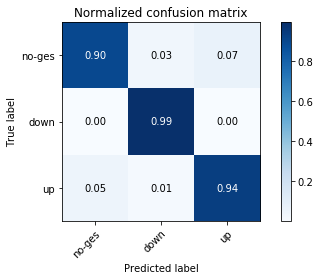

In [12]:
plot_confusion_matrix(test_target.argmax(axis=1), 
                      test_preds.argmax(axis=1), 
                      ['no-ges', 'down', 'up']
                     )

Confusion matrix, without normalization
[[2775  107  209]
 [  15 3160    3]
 [ 152   39 2879]]


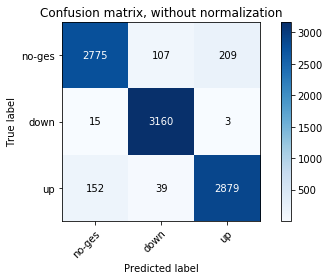

In [13]:
plot_confusion_matrix(test_target.argmax(axis=1), 
                      test_preds.argmax(axis=1), 
                      ['no-ges', 'down', 'up'],
                      normalize=False
                     )